<a href="https://colab.research.google.com/github/marcomag416/MLDL/blob/main/lab03_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PyTorch AlexNet Exercises

Welcome to the PyTorch AlexNet exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.






In [ ]:
import requests
from zipfile import ZipFile
from io import BytesIO

# Define the path to the dataset
dataset_path = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'  # Replace with the path to your dataset

# Send a GET request to the URL
response = requests.get(dataset_path)
# Check if the request was successful
if response.status_code == 200:
    # Open the downloaded bytes and extract them
    with ZipFile(BytesIO(response.content)) as zip_file:
        zip_file.extractall('./dataset')
    print('Download and extraction complete!')

dataset_path = "./dataset/tiny-imagenet-200/train"


Download and extraction complete!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

torch.manual_seed(27)

# Define the AlexNet architecture
class AlexNet(nn.Module):
    def __init__(self, num_classes=200):  # Tiny ImageNet has 200 classes
        super(AlexNet, self).__init__()
        # Define the layers of AlexNet
        self.layers_stack = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=0),
            nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=0),
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(9216, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.layers_stack(x)
        return x


# Define transforms for the input data
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Resize images to match AlexNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the Tiny ImageNet dataset
# Note: You'll need to download the dataset and set the correct path.
dataset = datasets.ImageFolder(dataset_path, transform=transform)
#split dataset into 60% train 20% validation and 20% test
[train_dataset, val_dataset, test_dataset] = torch.utils.data.random_split(dataset, [0.6, 0.2, 0.2], generator=torch.Generator().manual_seed(42))

# Training loop
def train(epoch, model, train_loader, criterion, optimizer, device, verbose=False):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        # todo
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        '''
        What's the correct order of those instructions?
        1. optimizer.zero_grad()
        2. loss = criterion(outputs, targets)
        3. outputs = model(inputs)
        4. optimizer.step()
        5. loss.backward()

        '''
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    if(verbose):
      print(f'Train Epoch: {epoch} Loss: {train_loss:.6f} Acc: {train_accuracy:.2f}%')
    return train_accuracy

# Test loop
def test(model, test_loader, criterion, device, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_loss = test_loss / len(test_loader)
    test_accuracy = 100. * correct / total
    if(verbose):
      print(f'Test Loss: {test_loss:.6f} Acc: {test_accuracy:.2f}%')
    return test_accuracy

def plot_accuracies(train_accuracies, val_accuracies):
  #plot the results
  plt.figure(figsize=(8,6))
  plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train set")
  plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation set")

  plt.xlabel("Epoch")
  plt.ylabel("Accuracy [%]")

  plt.legend()

  plt.show()

def train_val_step(train_dataset, val_dataset, lr, batch_size, num_epochs, weight_decay=5e-4):
  # Data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize the network
        net = AlexNet(num_classes=200).cuda()

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

        train_accuracies = [0] * num_epochs
        val_accuracies = [0] * num_epochs
        # Train the network

        print(f"STARTING NEW COMBINATION. Learning rate: {lr}, batch size: {batch_size}, number of epochs: {num_epochs}")
        for epoch in tqdm(range(num_epochs)):
            # Training loop
            train_accuracies[epoch] = train(epoch, net, train_loader, criterion, optimizer, 'cuda', verbose=True)

            # Validation loop
            val_accuracies[epoch] = test(net, val_loader, criterion, 'cuda', verbose=False)

        # Evaluate on the validation set and print results
        test(net, val_loader, criterion, 'cuda', verbose=True)

        plot_accuracies(train_accuracies, val_accuracies)

        # You can save the model state if you want to keep it
        torch.save(net.state_dict(), f'alexnet_lr{lr}_bs{batch_size}.pth')


# To analyze the effect of weight decay, you can vary the weight_decay parameter
# in the SGD optimizer and repeat the training and evaluation process.


## Note
The hyperparameter search has been splitted in multiple blocks in order to avoid colab timeout

STARTING NEW COMBINATION. Learning rate: 0.1, batch size: 16, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.298373 Acc: 0.50%
Train Epoch: 1 Loss: 5.298317 Acc: 0.49%
Train Epoch: 2 Loss: 5.298317 Acc: 0.49%
Train Epoch: 3 Loss: 5.298317 Acc: 0.49%
Train Epoch: 4 Loss: 5.298317 Acc: 0.49%
Train Epoch: 5 Loss: 5.298317 Acc: 0.49%
Train Epoch: 6 Loss: 5.298317 Acc: 0.49%
Train Epoch: 7 Loss: 5.298317 Acc: 0.49%
Train Epoch: 8 Loss: 5.298317 Acc: 0.49%
Train Epoch: 9 Loss: 5.298317 Acc: 0.49%
Test Loss: 5.298317 Acc: 0.53%


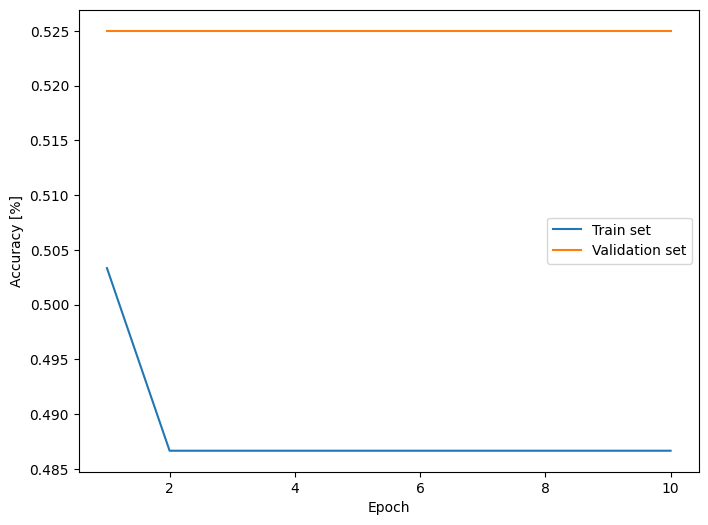

STARTING NEW COMBINATION. Learning rate: 0.1, batch size: 32, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.298402 Acc: 0.53%
Train Epoch: 1 Loss: 5.298319 Acc: 0.49%
Train Epoch: 2 Loss: 5.298319 Acc: 0.49%
Train Epoch: 3 Loss: 5.298319 Acc: 0.49%
Train Epoch: 4 Loss: 5.298319 Acc: 0.49%
Train Epoch: 5 Loss: 5.298319 Acc: 0.49%
Train Epoch: 6 Loss: 5.298319 Acc: 0.49%
Train Epoch: 7 Loss: 5.298319 Acc: 0.49%
Train Epoch: 8 Loss: 5.298319 Acc: 0.49%
Train Epoch: 9 Loss: 5.298319 Acc: 0.49%
Test Loss: 5.298319 Acc: 0.53%


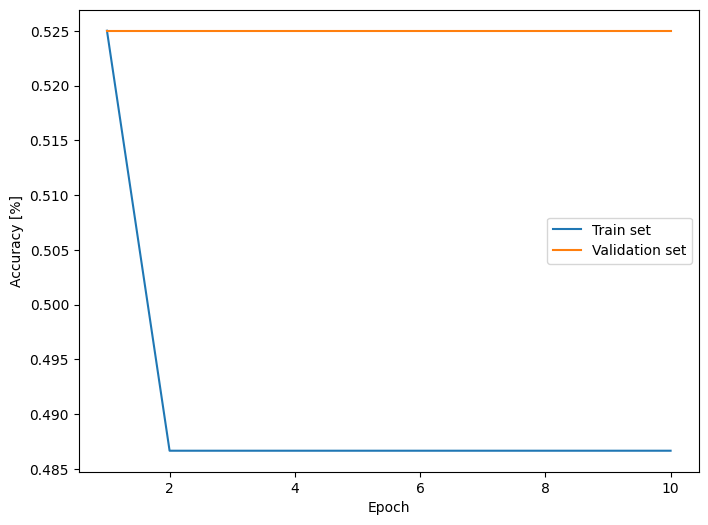

STARTING NEW COMBINATION. Learning rate: 0.1, batch size: 64, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.298235 Acc: 0.58%
Train Epoch: 1 Loss: 5.297648 Acc: 0.56%
Train Epoch: 2 Loss: 5.298319 Acc: 0.49%
Train Epoch: 3 Loss: 5.298319 Acc: 0.49%
Train Epoch: 4 Loss: 5.298319 Acc: 0.49%
Train Epoch: 5 Loss: 5.298319 Acc: 0.49%
Train Epoch: 6 Loss: 5.298319 Acc: 0.49%
Train Epoch: 7 Loss: 5.298319 Acc: 0.49%
Train Epoch: 8 Loss: 5.298319 Acc: 0.49%
Train Epoch: 9 Loss: 5.298319 Acc: 0.49%
Test Loss: 5.298319 Acc: 0.53%


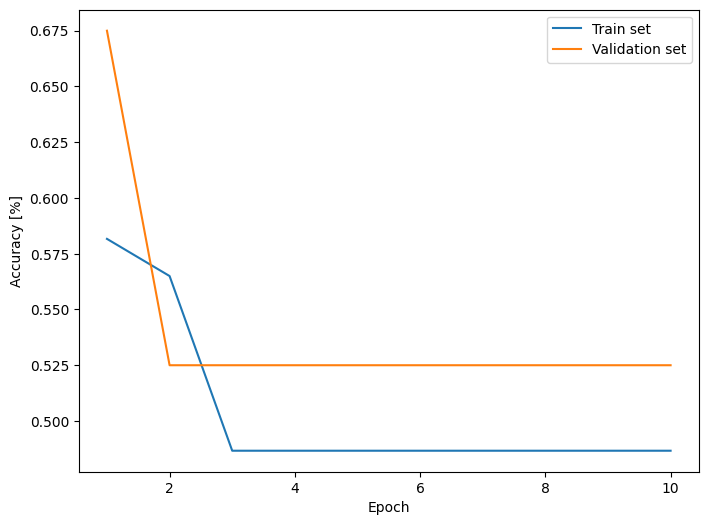

In [ ]:
# Hyperparameters
learning_rates = [0.1]
batch_sizes = [16, 32, 64]
num_epochs = 10

torch.manual_seed(27)

# Loop over hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:
        train_val_step(train_dataset, val_dataset, lr, batch_size, num_epochs)

STARTING NEW COMBINATION. Learning rate: 0.001, batch size: 16, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.298165 Acc: 0.52%
Train Epoch: 1 Loss: 5.269584 Acc: 1.10%
Train Epoch: 2 Loss: 5.061040 Acc: 3.34%
Train Epoch: 3 Loss: 4.741175 Acc: 6.53%
Train Epoch: 4 Loss: 4.356567 Acc: 10.60%
Train Epoch: 5 Loss: 3.907569 Acc: 15.93%
Train Epoch: 6 Loss: 3.491618 Acc: 22.03%
Train Epoch: 7 Loss: 3.094160 Acc: 28.78%
Train Epoch: 8 Loss: 2.631615 Acc: 36.65%
Train Epoch: 9 Loss: 2.026141 Acc: 48.59%
Test Loss: 3.753057 Acc: 23.75%


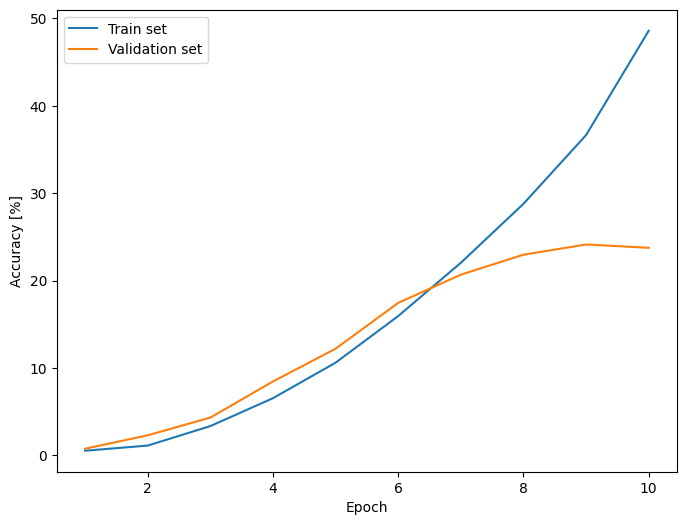

STARTING NEW COMBINATION. Learning rate: 0.001, batch size: 32, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.298189 Acc: 0.50%
Train Epoch: 1 Loss: 5.297403 Acc: 0.57%
Train Epoch: 2 Loss: 5.272029 Acc: 1.10%
Train Epoch: 3 Loss: 5.102980 Acc: 2.50%
Train Epoch: 4 Loss: 4.840065 Acc: 5.07%
Train Epoch: 5 Loss: 4.536162 Acc: 8.16%
Train Epoch: 6 Loss: 4.253709 Acc: 11.18%
Train Epoch: 7 Loss: 3.931903 Acc: 15.46%
Train Epoch: 8 Loss: 3.623276 Acc: 20.07%
Train Epoch: 9 Loss: 3.290546 Acc: 25.11%
Test Loss: 3.640978 Acc: 20.79%


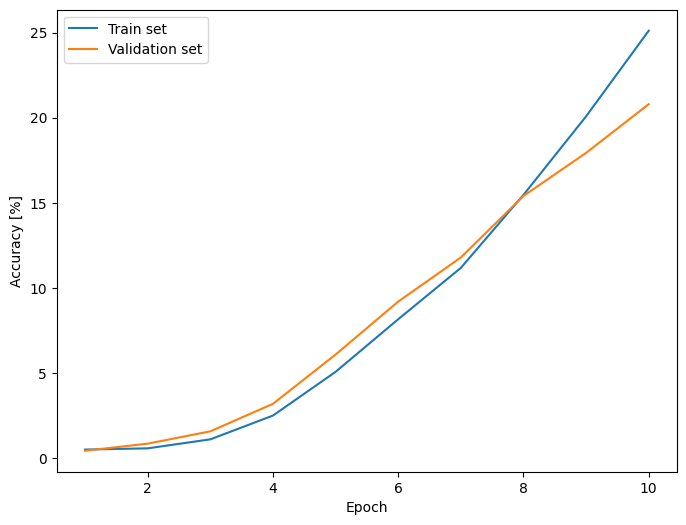

STARTING NEW COMBINATION. Learning rate: 0.001, batch size: 64, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.298246 Acc: 0.50%
Train Epoch: 1 Loss: 5.297896 Acc: 0.65%
Train Epoch: 2 Loss: 5.297389 Acc: 0.78%
Train Epoch: 3 Loss: 5.296149 Acc: 0.81%
Train Epoch: 4 Loss: 5.278722 Acc: 0.96%
Train Epoch: 5 Loss: 5.177596 Acc: 2.07%
Train Epoch: 6 Loss: 5.022338 Acc: 3.67%
Train Epoch: 7 Loss: 4.818134 Acc: 5.57%
Train Epoch: 8 Loss: 4.595527 Acc: 7.64%
Train Epoch: 9 Loss: 4.375855 Acc: 10.37%
Test Loss: 4.340062 Acc: 10.74%


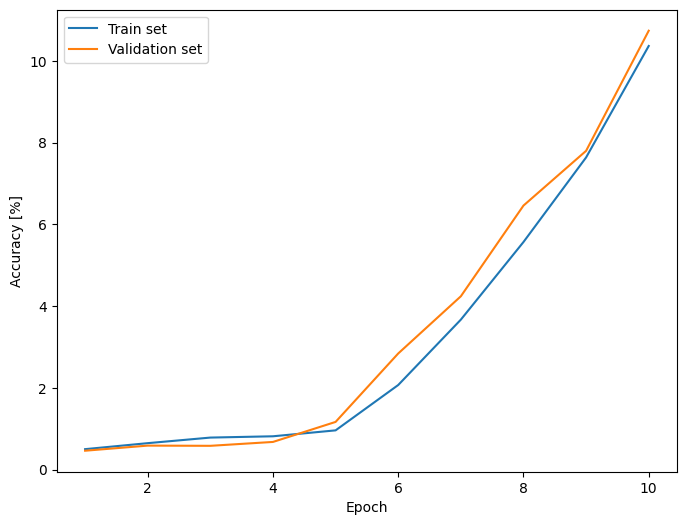

In [ ]:
# Hyperparameters
learning_rates = [0.001]
batch_sizes = [16, 32, 64]
num_epochs = 10

torch.manual_seed(27)

# Loop over hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:
        train_val_step(train_dataset, val_dataset, lr, batch_size, num_epochs)

STARTING NEW COMBINATION. Learning rate: 0.0001, batch size: 16, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.298338 Acc: 0.52%
Train Epoch: 1 Loss: 5.298250 Acc: 0.55%
Train Epoch: 2 Loss: 5.298170 Acc: 0.57%
Train Epoch: 3 Loss: 5.298085 Acc: 0.64%
Train Epoch: 4 Loss: 5.297992 Acc: 0.68%
Train Epoch: 5 Loss: 5.297886 Acc: 0.81%
Train Epoch: 6 Loss: 5.297758 Acc: 0.73%
Train Epoch: 7 Loss: 5.297594 Acc: 0.79%
Train Epoch: 8 Loss: 5.297366 Acc: 0.83%
Train Epoch: 9 Loss: 5.297027 Acc: 0.84%
Test Loss: 5.297057 Acc: 0.78%


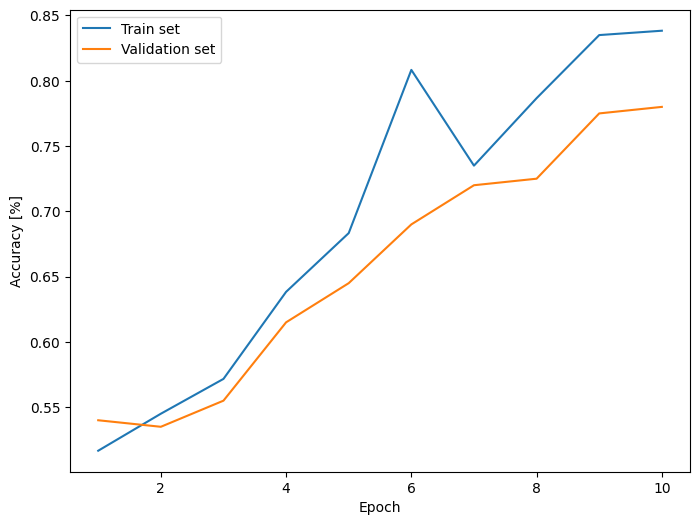

STARTING NEW COMBINATION. Learning rate: 0.0001, batch size: 32, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.298308 Acc: 0.48%
Train Epoch: 1 Loss: 5.298247 Acc: 0.48%
Train Epoch: 2 Loss: 5.298190 Acc: 0.53%
Train Epoch: 3 Loss: 5.298133 Acc: 0.51%
Train Epoch: 4 Loss: 5.298075 Acc: 0.52%
Train Epoch: 5 Loss: 5.298015 Acc: 0.57%
Train Epoch: 6 Loss: 5.297952 Acc: 0.57%
Train Epoch: 7 Loss: 5.297882 Acc: 0.63%
Train Epoch: 8 Loss: 5.297806 Acc: 0.65%
Train Epoch: 9 Loss: 5.297725 Acc: 0.62%
Test Loss: 5.297953 Acc: 0.51%


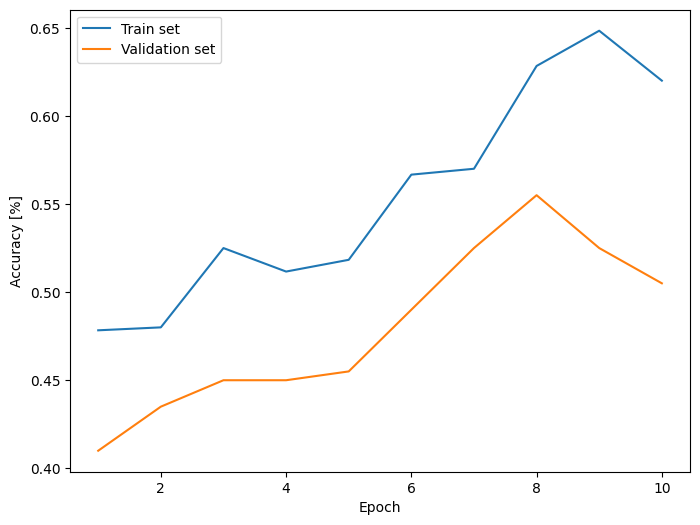

STARTING NEW COMBINATION. Learning rate: 0.0001, batch size: 64, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.298333 Acc: 0.49%
Train Epoch: 1 Loss: 5.298294 Acc: 0.49%
Train Epoch: 2 Loss: 5.298258 Acc: 0.49%
Train Epoch: 3 Loss: 5.298224 Acc: 0.49%
Train Epoch: 4 Loss: 5.298190 Acc: 0.48%
Train Epoch: 5 Loss: 5.298156 Acc: 0.47%
Train Epoch: 6 Loss: 5.298123 Acc: 0.46%
Train Epoch: 7 Loss: 5.298087 Acc: 0.48%
Train Epoch: 8 Loss: 5.298053 Acc: 0.57%
Train Epoch: 9 Loss: 5.298017 Acc: 0.57%
Test Loss: 5.298042 Acc: 0.46%


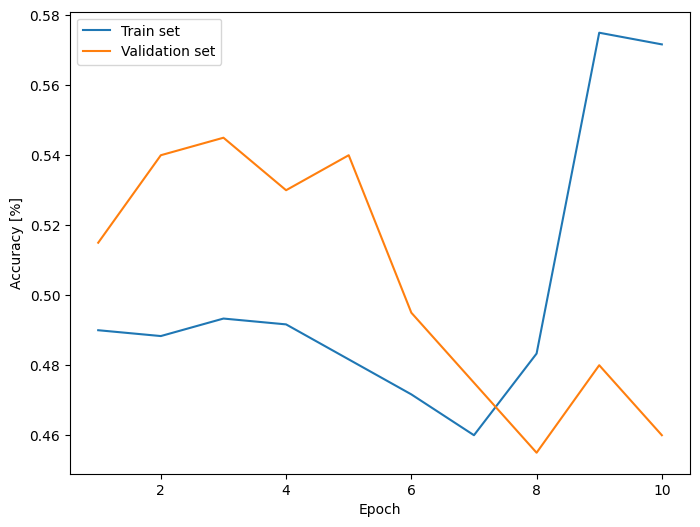

In [ ]:
# Hyperparameters
learning_rates = [0.0001]
batch_sizes = [16, 32, 64]
num_epochs = 10

torch.manual_seed(27)

# Loop over hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:
        train_val_step(train_dataset, val_dataset, lr, batch_size, num_epochs)

STARTING NEW COMBINATION. Learning rate: 0.001, batch size: 16, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.298356 Acc: 0.47%
Train Epoch: 1 Loss: 5.298285 Acc: 0.51%
Train Epoch: 2 Loss: 5.298309 Acc: 0.50%
Train Epoch: 3 Loss: 5.298306 Acc: 0.50%
Train Epoch: 4 Loss: 5.298299 Acc: 0.50%
Train Epoch: 5 Loss: 5.298294 Acc: 0.49%
Train Epoch: 6 Loss: 5.298293 Acc: 0.51%
Train Epoch: 7 Loss: 5.298293 Acc: 0.53%
Train Epoch: 8 Loss: 5.298294 Acc: 0.53%
Train Epoch: 9 Loss: 5.298292 Acc: 0.47%
Test Loss: 5.298479 Acc: 0.43%


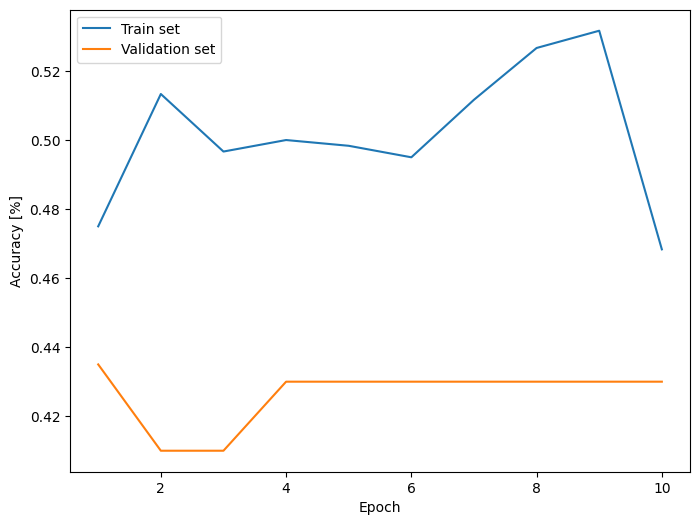

STARTING NEW COMBINATION. Learning rate: 0.001, batch size: 16, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.297995 Acc: 0.63%
Train Epoch: 1 Loss: 5.245406 Acc: 1.23%
Train Epoch: 2 Loss: 4.983760 Acc: 3.63%
Train Epoch: 3 Loss: 4.616154 Acc: 7.21%
Train Epoch: 4 Loss: 4.187811 Acc: 11.82%
Train Epoch: 5 Loss: 3.754503 Acc: 17.80%
Train Epoch: 6 Loss: 3.383421 Acc: 23.55%
Train Epoch: 7 Loss: 3.001838 Acc: 30.16%
Train Epoch: 8 Loss: 2.539579 Acc: 38.23%
Train Epoch: 9 Loss: 1.946074 Acc: 50.18%
Test Loss: 3.773982 Acc: 23.46%


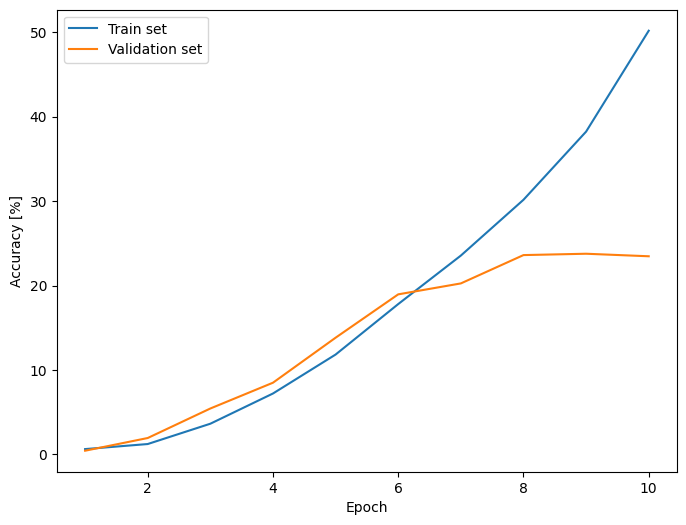

STARTING NEW COMBINATION. Learning rate: 0.001, batch size: 16, number of epochs: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 Loss: 5.297801 Acc: 0.56%
Train Epoch: 1 Loss: 5.233498 Acc: 1.43%
Train Epoch: 2 Loss: 4.993812 Acc: 3.79%
Train Epoch: 3 Loss: 4.596332 Acc: 8.03%
Train Epoch: 4 Loss: 4.159775 Acc: 12.97%
Train Epoch: 5 Loss: 3.703989 Acc: 19.16%
Train Epoch: 6 Loss: 3.281805 Acc: 25.33%
Train Epoch: 7 Loss: 2.840906 Acc: 32.92%
Train Epoch: 8 Loss: 2.283587 Acc: 43.23%
Train Epoch: 9 Loss: 1.564412 Acc: 58.89%
Test Loss: 4.087574 Acc: 23.58%


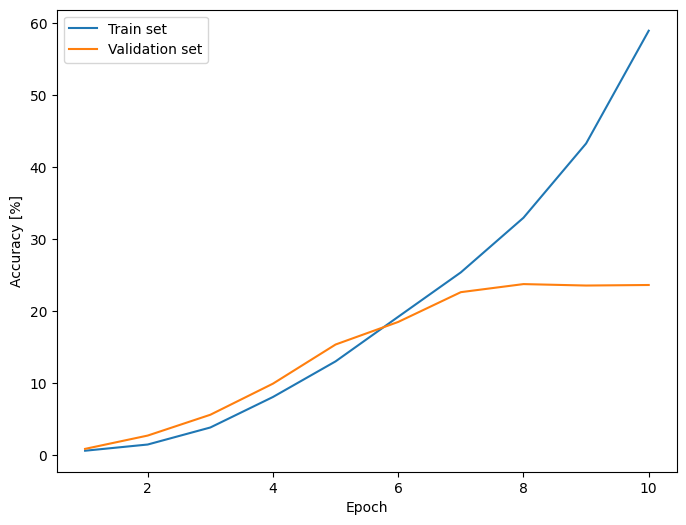

In [ ]:
# Hyperparameters
learning_rate = 0.001
batch_size = 16
num_epochs = 10
weight_decay = [5e-3, 5e-4, 5e-5 ]

torch.manual_seed(27)

# Loop over hyperparameters
for wd in weight_decay:
  train_val_step(train_dataset, val_dataset, learning_rate, batch_size, num_epochs, weight_decay=wd)

## Results
Best results are achieved by lr=0.001 with batch_size=32 and 64. A longer training may be performed on these hyperparameters in order to obtain better performance. Increasing weight decay will reduce overfitting but a too high value may result in poor performance.